In [1]:
%pylab inline

import os.path as op
import sys
import matplotlib.pyplot as plt
import glob

import io3d
import sed3


sys.path.append(op.expanduser("~/projects/bodynavigation"))

import bodynavigation
pt = op.expanduser("~/projects/imtools")
sys.path.append(pt)
import imtools
# reload(imtools)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")

## Train

Prepare function to calculate feature vector from 3D to [1D x number_of_features]

In [3]:
def localization_fv(data3d, voxelsize_mm):        # scale
        fv = []
        # f0 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=3).reshape(-1, 1)
        #f1 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=1).reshape(-1, 1) - f0
        #f2 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=5).reshape(-1, 1) - f0
        #f3 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=10).reshape(-1, 1) - f0
        #f4 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=20).reshape(-1, 1) - f0
        # position asdfas
        import bodynavigation as bn
        ss = bn.BodyNavigation(data3d, voxelsize_mm)
        fd1 = ss.dist_to_lungs().reshape(-1, 1)
        fd2 = ss.dist_to_spine().reshape(-1, 1)
        fd3 = ss.dist_sagittal().reshape(-1, 1)
        fd4 = ss.dist_coronal().reshape(-1, 1)
        fd5 = ss.dist_axial().reshape(-1, 1)
        fd6 = ss.dist_to_surface().reshape(-1, 1)
        fd7 = ss.dist_diaphragm().reshape(-1, 1)

        # f6 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[20, 1, 1]).reshape(-1, 1) - f0
        # f7 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[1, 20, 1]).reshape(-1, 1) - f0
        # f8 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[1, 1, 20]).reshape(-1, 1) - f0

        # print "fv shapes ", f0.shape, fd2.shape, fd3.shape
        fv = np.concatenate([
                # f0,
#                 f1, f2, f3, f4,
                fd1, fd2, fd3, fd4, fd5, fd6, fd7,
                #f6, f7, f8
            ], 1)


        return fv

In [ ]:
import imtools.trainer3d
import imtools.datasets
ol = imtools.trainer3d.Trainer3D()
ol.feature_function = localization_fv

for one in imtools.datasets.sliver_reader(
    "*[0-7].mhd", read_seg=True,
    sliver_reference_dir=sliver_reference_dir):
    
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
    ol.add_train_data(orig_data, ref_data, voxelsize_mm=vs_mm)
    
ol.fit()

## Testing

In [5]:
one = list(imtools.datasets.sliver_reader("*018.mhd", read_seg=True))[0]
numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
fit = ol.predict(orig_data, voxelsize_mm=vs_mm)

(163, 253, 253)
(10433467,)


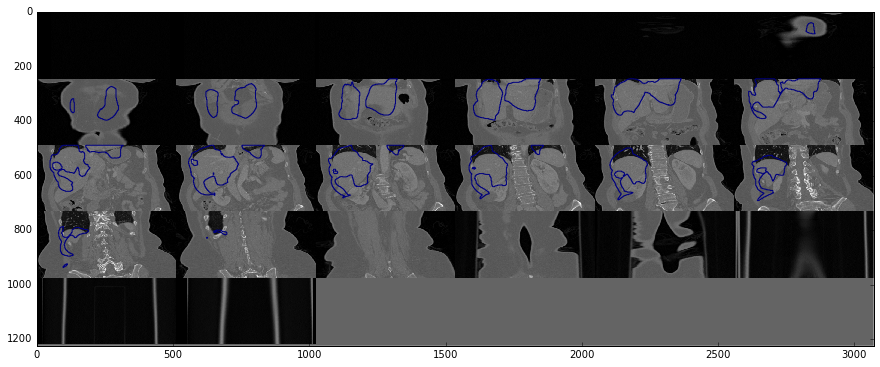

In [6]:
plt.figure(figsize=(15,10))
sed3.show_slices(orig_data, fit, slice_step=20, axis=1, flipV=True)

### Evaluation

In [9]:
import lisa.volumetry_evaluation
lisa.volumetry_evaluation.compare_volumes_sliver(ref_data, fit, vs_mm)

{'avgd': 12.031323575619316,
 'err1_mm3': 651297.31080045528,
 'err1_percent': 33.201476030839608,
 'err2_mm3': 976534.7324271265,
 'err2_percent': 49.781250397171064,
 'maxd': 81.199392314138294,
 'rmsd': 249.99430098132265,
 'sliver_avgd_pts': 0,
 'sliver_maxd_pts': 0,
 'sliver_overall_pts': 5.8762045691008975,
 'sliver_rmsd_pts': 0,
 'sliver_vd_pts': 29.381022845504489,
 'sliver_voe_pts': 0,
 'vd': 18.078458151550851,
 'voe': 41.491363214005339,
 'volume1_mm3': 1799032.9645383554,
 'volume2_mm3': 2124270.3861650266}